/Users/yuhangya/Library/Python/3.8/lib/python/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


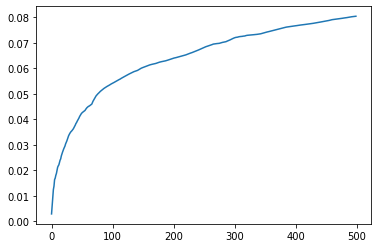

In [2]:
# soft constraints

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

N = 1
T = 500
m = 20  # number of devices
n = 5  # number of servers
y_max = 110
y_min = 90
rs = 0.1
beta = np.ones(n)
# beta[0] = 5
# beta[1] = 5
# beta[3] = 5
gamma = 0.0001

def optimization(m, n, wS, y, mu, BS, beta):
    x = cp.Variable((n + 1, m), nonneg=True)
    obj = beta @ cp.inv_pos(cp.sqrt(x[1:, :] @ y + wS)) + gamma * cp.sum(cp.multiply(cp.diag(mu @ x[1:, :]), y))

    constraints = [0 <= x, x <= 1,
                   x[1:, :] @ y <= BS,
                   cp.sum(x, 0) == 1]

    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve()  # Returns the optimal value.
    return x, prob

def oracle(y, mu):
    x, prob = optimization(m, n, wS, y, mu, BS, beta)
    return x.value, prob.value, prob.status

def f(x, y, mu):
    return beta.dot(1/np.sqrt(x[1:, :].dot(y) + wS)) + gamma * np.sum((y*x[1:]).T*mu)

def f_drop(x, y, mu, BS, gamma):
    dp = np.minimum(x[1:, :].dot(y), BS)
    return beta.dot(1/np.sqrt(dp + wS)) + gamma * np.sum((y*x[1:]).T*mu)

reg = np.zeros((N, T))

#records all y, x_opt, x_t #yuhang yao
y_N_T = np.zeros((N, T, m)) #yuhang yao
x_opt_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
x_t_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
j_N_T = np.zeros((N, T, m))#yuhang yao
BS_N = np.zeros((N, n))#yuhang yao

for u in range(N):
    wS = np.random.randint(15, 25, n)
    BS = np.random.uniform(y_min*10, y_max*10, n)
    BS_N[u] = BS
    mu = np.random.rand(m, n)
    mu[:,0] = 0.5
    mu[:,1] = 0.5
    mu[:,2] = 0.8
    mu[:,3] = 0.8
    mu[:,4] = 0.8
    # trace_gen = Trace(m, n, seed + u)
    # mu = trace_gen.avg()
    # mu = np.random.rand(m, n)
    # mu_hat = np.zeros_like(mu)  # empirical mean
    mu_hat = np.zeros_like(mu)
    T_ij = np.ones_like(mu)  # total number of times arm (i,j) is played
    for t in range(T):
        y = np.random.uniform(y_min, y_max, m).astype(int)
        x_opt, f_opt, status = oracle(y, mu)
        if 'optimal' not in status:
            print('Solution infeasible 1')
            break

        rho_ij = np.sqrt(3 * np.log(t + 1) / (2 * T_ij)) * rs
        mu_bar = np.maximum(mu_hat - rho_ij, 0) # LCB
        x_t, _, status = oracle(y, mu_bar)
        if 'optimal' not in status:
            print('Solution infeasible 2')
            break

        f_t = f(x_t, y, mu)

        # sample j based on x_t[i], observe c_ij, update mu_hat[i,j]
        # c = trace_gen.generate()
        for i in range(m):
            j = np.random.choice(n+1, p=x_t[:, i])
            j_N_T[u, t, i] = j #yuhang yao
            if j != 0:
                j -= 1
                c_ij = int(np.random.rand() < mu[i, j])
                # a = np.random.rand() * 3
                # c_ij = np.random.beta(a, a * (1-mu[i, j])/mu[i, j]) # beta distribution
                # c_ij = c[i, j]  # trace
                T_ij[i, j] += 1
                mu_hat[i, j] += (c_ij - mu_hat[i, j]) / T_ij[i, j]

        # calculate regert
        reg[u, t] = f_t - f_opt
        y_N_T[u, t] = y#yuhang yao
        x_opt_N_T[u, t] = x_opt#yuhang yao
        x_t_N_T[u, t] = x_t#yuhang yao
        
plt.plot(np.cumsum(reg, axis=1).T)

In [ ]:
CD

In [ ]:
y_N_T[0,0]

In [ ]:

np.save("hard_wS", wS)
np.save("hard_BS_N", BS_N)
np.save("hard_y_N_T", y_N_T)
np.save("hard_x_opt_N_T", x_opt_N_T)
np.save("hard_x_t_N_T", x_t_N_T)
np.save("hard_j_N_T", j_N_T)

In [ ]:
from functions import *
wS = np.load("hard_wS.npy")
y_N_T = np.load("hard_y_N_T.npy")
x_opt_N_T = np.load("hard_x_opt_N_T.npy")
x_t_N_T = np.load("hard_x_t_N_T.npy")
j_N_T = np.load("hard_j_N_T.npy")
BS_N = np.load("hard_BS_N.npy")




In [ ]:
N = 1
T = 50
m = 20  # number of devices
n = 5  # number of servers
y_max = 110
y_min = 90
rs = 0.1
beta = np.ones(n)
# beta[0] = 5
# beta[1] = 5
# beta[3] = 5
gamma = 0.0001



In [ ]:

wS = wS.astype(int)
BS_N = BS_N.astype(int)
y_N_T = y_N_T.astype(int)

j_N_T = j_N_T.astype(int)

In [ ]:
Data_num_S_N_T = np.zeros((N, T, wS.shape[0]))
for u in range(N):
    for t in range(T):
        Data_num_S_N_T[u, t] = wS
        for i in range(m):
            
                    j = j_N_T[u, t, i]#np.random.choice(n + 1, p=x_t_N_T[u, t, :, i])
                    
                    if j != 0:
                        j -= 1
                        Data_num_S_N_T[u, t, j] += y_N_T[u, t, i] #upload to device j-1
                        Data_num_S_N_T[u, t, j] = min(Data_num_S_N_T[u, t, j], BS_N[u, j])

In [ ]:
Data_num_S_N_T = np.zeros((N, T, wS.shape[0]))
for u in range(N):
    for t in range(T):
        Data_num_S_N_T[u, t] = wS
        for i in range(m):
            
                    j = j_N_T[u, t, i]#np.random.choice(n + 1, p=x_t_N_T[u, t, :, i])
                    
                    if j != 0:
                        j -= 1
                        Data_num_S_N_T[u, t, j] += y_N_T[u, t, i] #upload to device j-1
                        Data_num_S_N_T[u, t, j] = min(Data_num_S_N_T[u, t, j], BS_N[u, j])

from fed_train import fed_T
import time
save_time = str(time.time())
import torch
torch.manual_seed(seed)

total_loss_train = []
total_accuracy_train = []

total_acc_test = 0
total_loss_test = 0

for u in range(N):
    L_T = []
    for t in range(T):
        L = list(Data_num_S_N_T[u, t])
        L_T.append(L)
    L_T = np.array(L_T).astype(int)



    loss_train, accuracy_train, acc_test, loss_test, args = fed_T(L_T, "mnist", True)
    if len(total_loss_train) == 0:
        total_loss_train = np.array(loss_train)
    else:
        total_loss_train += np.array(loss_train)
        
    if len(total_accuracy_train) == 0:
        total_accuracy_train = np.array(accuracy_train)
    else:
        total_accuracy_train += np.array(accuracy_train)
    
    total_acc_test += acc_test
    total_loss_test += loss_test
    
total_loss_train /= N
total_acc_test /= N
total_loss_test /= N

plt.figure()
plt.plot(range(len(total_loss_train)), total_loss_train)
plt.ylabel('train_loss')
plt.savefig('./save/' + save_time + 'fed_{}_{}_{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.iid))

print(total_acc_test, total_loss_test)

In [ ]:
Data_num_S_N_T = np.zeros((N, T, wS.shape[0]))
for u in range(N):
    for t in range(T):
        Data_num_S_N_T[u, t] = wS
        for i in range(m):
            
                    j = np.random.choice(n + 1)
                    
                    if j != 0:
                        j -= 1
                        Data_num_S_N_T[u, t, j] += y_N_T[u, t, i] #upload to device j-1
                        Data_num_S_N_T[u, t, j] = min(Data_num_S_N_T[u, t, j], BS_N[u, j])

from fed_train import fed_T
import time
save_time = str(time.time())
import torch
torch.manual_seed(seed)

total_loss_train = []
total_accuracy_train = []

total_acc_test = 0
total_loss_test = 0

for u in range(N):
    L_T = []
    for t in range(T):
        L = list(Data_num_S_N_T[u, t])
        L_T.append(L)
    L_T = np.array(L_T).astype(int)



    loss_train, accuracy_train, acc_test, loss_test, args = fed_T(L_T, "mnist", True)
    if len(total_loss_train) == 0:
        total_loss_train = np.array(loss_train)
    else:
        total_loss_train += np.array(loss_train)
        
    if len(total_accuracy_train) == 0:
        total_accuracy_train = np.array(accuracy_train)
    else:
        total_accuracy_train += np.array(accuracy_train)
    
    total_acc_test += acc_test
    total_loss_test += loss_test
    
total_loss_train /= N
total_acc_test /= N
total_loss_test /= N

plt.figure()
plt.plot(range(len(total_loss_train)), total_loss_train)
plt.ylabel('train_loss')
plt.savefig('./save/' + save_time + 'fed_{}_{}_{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.iid))

print(total_acc_test, total_loss_test)